In [28]:
import torch
import os
import math
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from copy import deepcopy
from time import time
import numpy as np
from PIL import Image
from torchvision import models
from tqdm import tqdm
from torch.utils.data.dataset import Dataset

# just to ignore the matplotlib warnings to make the plots look better
import warnings
warnings.filterwarnings('ignore')
# test whether the cuda is available
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'


print(torch.__version__)
print(torch.cuda.is_available())

1.13.0+cu117
True


In [29]:
import pandas as pd
train_biz=pd.read_csv('./train_photo_to_biz_ids.csv')
test_biz=pd.read_csv('./test_photo_to_biz.csv')
train=pd.read_csv('./train.csv')
sub=pd.read_csv('./sample_submission.csv')

#print(train_biz)
#print(test_biz)
#print(train)
#print(sub)

In [30]:
# merging
data=pd.merge(train_biz,train, on='business_id',how='left')
# drop data that missing labels
data=data.dropna(subset=['labels'])

# for competition only
data_task=pd.merge(test_biz,sub, on='business_id',how='left') 

In [31]:
# convert string to list of int
labels=data['labels'].tolist()
for index,x in enumerate(labels):
     labels[index]= [int(c) for c in str(x).split(' ')]
data['labels'] = labels

In [32]:
# use small data set for development
development_size=0.9
unsued_data,data = train_test_split(data,test_size=development_size, random_state=40)

train_data, test_data = train_test_split(data, test_size=0.1, random_state=40)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=40)


In [33]:
# Define dataset class


class Image_Dataset(Dataset):
    def __init__(self, data_path, data, transform=None):
        self.image_id = data['photo_id'].tolist()
        self.labels=data['labels'].tolist()
        self.transform = transform
        self.data_path = data_path
        self.classes = [0,1,2,3,4,5,6,7,8]
        
          
        for index in range(len(self.labels)):
            labels = self.labels[index]
            vector=[0,0,0,0,0,0,0,0,0]
            for i in range(9):
                if i in labels:
                    vector[i] = 1
            self.labels[index] = np.array(vector, dtype=float)

    def __getitem__(self, index):
        label = self.labels[index]
        img_path = os.path.join(self.data_path, str(self.image_id[index])+'.jpg')
        img = Image.open(img_path)
        if self.transform:
            # dont know why all output of the transform are negative
            img = -self.transform(img)
        return img, label
    def __len__(self):
        return len(self.image_id)



In [34]:
# transformation

mean = [0.485,0.456,0.406]
std = [0.229,0.224,0.225]

train_transform = transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        ])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [35]:
train_dataset = Image_Dataset('./train_photos', train_data, train_transform)
val_dataset = Image_Dataset('./train_photos', val_data, val_transform)
test_dataset = Image_Dataset('./train_photos', test_data, val_transform)

In [36]:
# this part can be tuned
class Resnext50(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=9)
        )
        self.model = resnet
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.model(x))

In [37]:
# this part can be tuned

device = torch.device('cuda')
model = Resnext50()
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_func = nn.BCELoss()

epoch = 5
#batch_size= 16
# lr = 1e-4 

 
#train_batch_size = 48
#val_batch_size =64
train_dataloader = DataLoader(train_dataset, batch_size=16,  shuffle=True,drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)


In [38]:
def train(model, optimizer,  device):
    train_precision = []
    train_recall=[]
    train_loss = []
    
    val_precision = []
    val_recall=[]
    val_loss = []
    
    best_f1 = 0
    best_model = None
    best_i = 0
    
    
    model = model.to(device)
    
    for i in range(epoch):
        model.train()
        
        batch_precision=[]
        batch_recall=[]
        batch_loss =[]
        for images, labels in tqdm(train_dataloader):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_func(output, labels.type(torch.float))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                pred = (output>0.5).cpu()
                labels = labels.cpu()
                batch_precision.append(precision_score(labels, pred,average='micro'))
                batch_recall.append(recall_score(labels, pred,average='micro'))
                batch_loss.append(loss.cpu())
                
        precision = np.array(batch_precision).mean()
        recall = np.array(batch_recall).mean()
        loss = np.array(batch_loss).mean()
        
        train_precision.append(precision)
        train_recall.append(recall)
        train_loss.append(loss)
        print("train_precision:{:.4f}, train_recall:{:.4f}, train_loss:{:.4f}".format(precision,recall,loss))

        # validation
        model.eval()
        model_result = []
        targets = []
        with torch.no_grad():
            for images, labels in tqdm(val_dataloader):
                images = images.to(device)
                model_batch_result = model(images)
                model_result.extend(model_batch_result.cpu().numpy())
                targets.extend(labels.cpu().numpy())
        
        loss = loss_func(torch.FloatTensor(model_result), torch.FloatTensor(targets))
        pred = np.array(np.array(model_result) >0.5, dtype=float)
        val_precision.append(precision_score(targets,pred,average='micro'))
        val_recall.append(recall_score(targets,pred,average='micro'))
        val_loss.append(loss.item())
        f1 = f1_score(targets,pred,average='micro')
        
        if  f1> best_f1:
            best_f1 = f1
            best_model = deepcopy(model.state_dict())
            best_i = i

        if i % 20 == 0:
            print('Epoch {}, val_precision:{:.4f}, val_recall:{:.4f}, val_loss:{:.4f}, f1:{:.4f}'.format(i, val_precision[-1],val_recall[-1],val_loss[-1],f1))

    print('best epoch {}, train precision {:.4f} val precision {:.4f}, f1 {:.4f}'.format(best_i, train_precision[best_i], val_precision[best_i], best_f1))
    model.load_state_dict(best_model)
    return train_precision, train_recall, train_loss, val_precision, val_recall, val_loss

In [39]:
def plot_graph(train_precision, train_recall, train_loss, val_precision, val_recall, val_loss):
    x=range(1,epoch+1)
    plt.xlabel("iteration")
    plt.plot(x,train_precision,label="train_precision")
    plt.plot(x,train_recall,label="train_recall")
    plt.plot(x,val_precision,label="val_precision")
    plt.plot(x,val_recall,label="val_recall")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    xint = range(1, epoch+1)
    matplotlib.pyplot.xticks(xint)
    plt.show()

    plt.xlabel("iteration")
    plt.plot(x,train_loss,label="train_loss")
    plt.plot(x,val_loss,label="val_loss")
    plt.legend(loc="lower left")
    xint = range(1, epoch+1)
    matplotlib.pyplot.xticks(xint)
    plt.show()

In [40]:
# Training

torch.cuda.empty_cache()
train_precision, train_recall, train_loss, val_precision, val_recall, val_loss = train(model, optimizer, device)




100%|██████████| 10686/10686 [1:41:57<00:00,  1.75it/s]


train_precision:0.7729, train_recall:0.7687, train_loss:0.4830


100%|██████████| 297/297 [04:22<00:00,  1.13it/s]


Epoch 0, val_precision:0.8063, val_recall:0.7841, val_loss:0.4407, f1:0.7950


100%|██████████| 10686/10686 [1:41:33<00:00,  1.75it/s]


train_precision:0.7998, train_recall:0.7960, train_loss:0.4392


100%|██████████| 10686/10686 [1:41:23<00:00,  1.76it/s]


train_precision:0.8128, train_recall:0.8098, train_loss:0.4153


100%|██████████| 10686/10686 [1:41:19<00:00,  1.76it/s]


train_precision:0.8229, train_recall:0.8207, train_loss:0.3959


100%|██████████| 10686/10686 [1:41:22<00:00,  1.76it/s]


train_precision:0.8325, train_recall:0.8309, train_loss:0.3778


100%|██████████| 297/297 [04:20<00:00,  1.14it/s]


best epoch 3, train precision 0.8229 val precision 0.8187, f1 0.8163


In [41]:
# Save model
PATH="./models/best_model.pt"
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), PATH)

In [42]:
# load best_model
model=Resnext50()
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()


Resnext50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

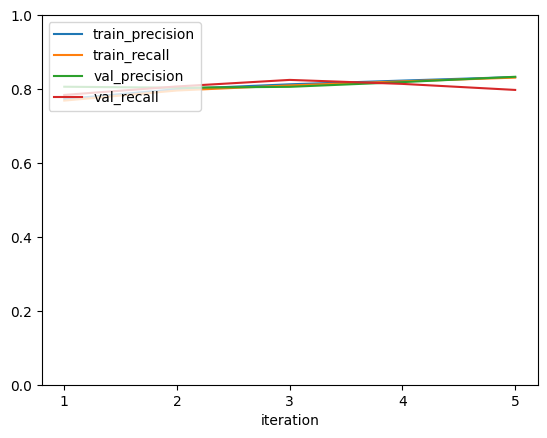

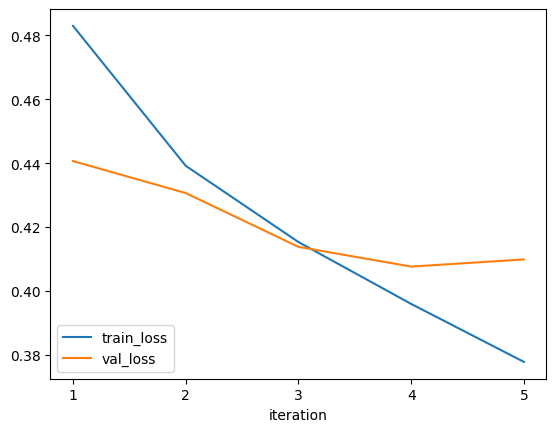

In [43]:
plot_graph(train_precision, train_recall, train_loss, val_precision, val_recall, val_loss)

In [44]:
# TODO:
# add regularization, tune hyper parameters

<class 'torch.Tensor'>
['good_for_dinner', 'takes_reservations', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']
['good_for_dinner', 'takes_reservations', 'outdoor_seating', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']


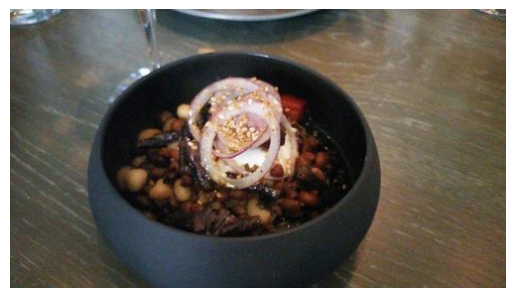

<class 'torch.Tensor'>
['good_for_lunch', 'outdoor_seating', 'good_for_kids']
['good_for_lunch', 'outdoor_seating', 'good_for_kids']


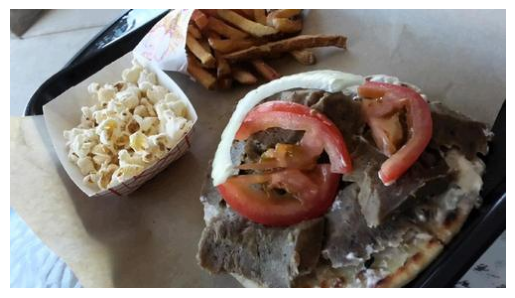

<class 'torch.Tensor'>
['good_for_dinner', 'takes_reservations', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']
['good_for_dinner', 'takes_reservations', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']


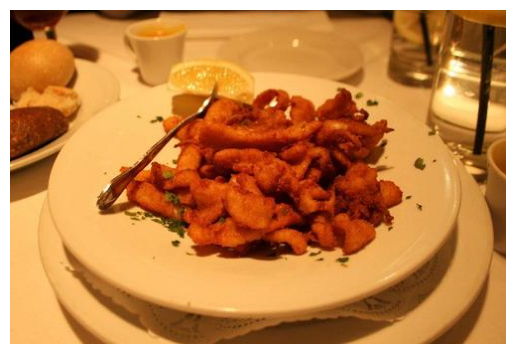

<class 'torch.Tensor'>
['good_for_lunch', 'good_for_dinner', 'takes_reservations', 'has_alcohol', 'has_table_service', 'good_for_kids']
['good_for_lunch', 'good_for_dinner', 'takes_reservations', 'has_alcohol', 'has_table_service', 'good_for_kids']


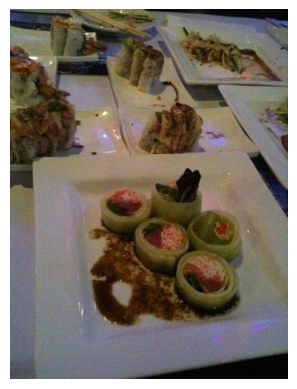

<class 'torch.Tensor'>
['good_for_dinner', 'takes_reservations', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']
['good_for_dinner', 'takes_reservations', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy', 'good_for_kids']


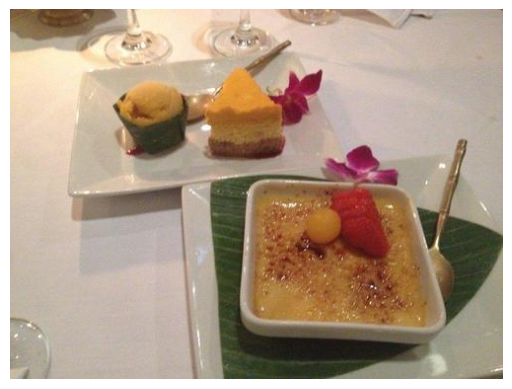

<class 'torch.Tensor'>
['good_for_dinner', 'takes_reservations', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']
['good_for_dinner', 'takes_reservations', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']


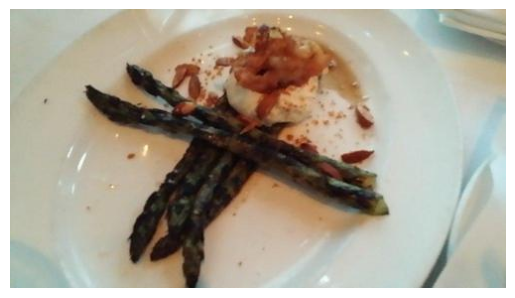

<class 'torch.Tensor'>
['good_for_dinner', 'takes_reservations', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'good_for_kids']
['good_for_lunch', 'takes_reservations', 'outdoor_seating', 'good_for_kids']


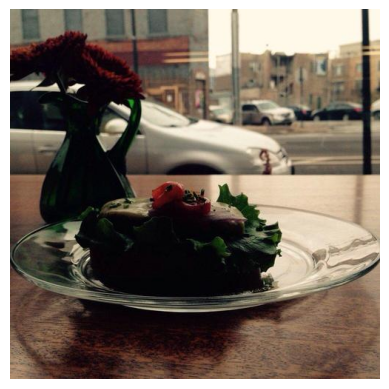

<class 'torch.Tensor'>
['good_for_dinner', 'takes_reservations', 'outdoor_seating', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']
['good_for_dinner', 'takes_reservations', 'outdoor_seating', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']


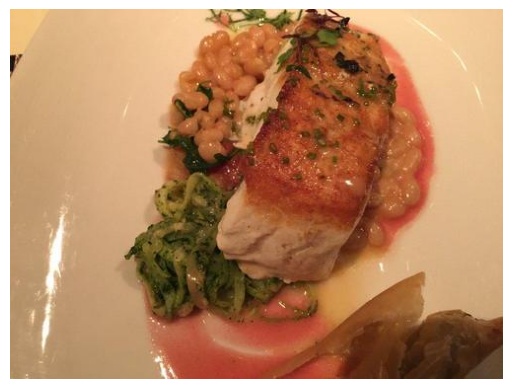

<class 'torch.Tensor'>
['good_for_kids']
['good_for_lunch', 'good_for_kids']


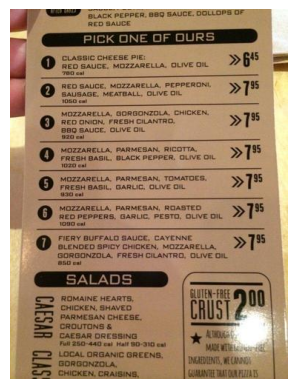

<class 'torch.Tensor'>
['good_for_dinner', 'takes_reservations', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service']
['good_for_dinner', 'takes_reservations', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service']


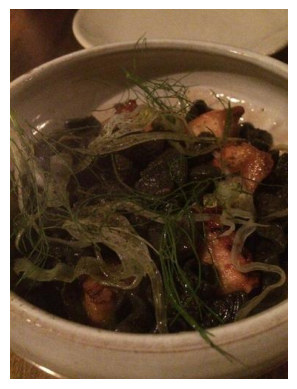

In [52]:
model.eval()
label_notation = {0: 'good_for_lunch', 1: 'good_for_dinner', 2: 'takes_reservations',  3: 'outdoor_seating',
                  4: 'restaurant_is_expensive', 5: 'has_alcohol', 6: 'has_table_service', 7: 'ambience_is_classy',
                  8: 'good_for_kids'}
if torch.cuda.is_available():
    model.cuda()
for sample_id in [1,2,3,4,6,7,8,9,10,11]:
    test_img, test_labels = test_dataset[sample_id]
    print(type(test_img))
    test_img = test_img.cuda()
    test_img_path = os.path.join('./train_photos', str(test_dataset.image_id[sample_id])+'.jpg')
    with torch.no_grad():
        raw_pred = model(test_img.unsqueeze(0)).cpu().numpy()[0]
        raw_pred = np.array(raw_pred > 0.5, dtype=float)

    predicted_labels = np.array(val_dataset.classes)[np.argwhere(raw_pred > 0)[:, 0]]
    if not len(predicted_labels):
        predicted_labels = ['no predictions']
    img_labels = np.array(val_dataset.classes)[np.argwhere(test_labels > 0)[:, 0]]
    
    result = [label_notation[p] for p in predicted_labels]
    expected = [label_notation[p] for p in img_labels]
    plt.imshow(Image.open(test_img_path))
    print(result)
    print(expected)
    plt.axis('off')
    plt.show()